<a href="https://colab.research.google.com/github/AguaClara/Textbook/blob/sedDesignChallenge2/Flocs_Fractals_and_Forces/Colab/FFF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install aguaclara
!pip install molmass

     |████████████████████████████████| 94 kB 1.8 MB/s 
     |████████████████████████████████| 209 kB 33.0 MB/s 
     |████████████████████████████████| 2.1 MB 50.5 MB/s 
     |████████████████████████████████| 109 kB 69.5 MB/s 
     |████████████████████████████████| 546 kB 55.3 MB/s 
  Created wheel for aguaclara: filename=aguaclara-0.2.10-py3-none-any.whl size=107244 sha256=e85d40e810d26332c584a2256b96a7dfc363d10f490c8b3ecf0833e2d01105f6
  Stored in directory: /root/.cache/pip/wheels/a3/12/ef/53d591c580e122cb62a84cb2180ddba9ba03bb3dc85b19285e
Successfully built aguaclara
     |████████████████████████████████| 66 kB 2.4 MB/s 


In [3]:
from aguaclara.core.units import unit_registry as u
import aguaclara as ac
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker

font = 'x-large'
params = {'legend.fontsize': font,
         'figure.figsize': (8,6),
         'axes.labelsize': font,
         'axes.titlesize':font,
         'xtick.labelsize':font,
         'ytick.labelsize':font,
         'axes.formatter.useoffset':False,
          'legend.framealpha':1} 
plt.rcParams.update(params)

In [4]:


def v_terminal(temp, particle_RHO , particle_D):
  """ calculate the terminal velocity both in the laminar and transition
  range. Uses iteration to find solution in the transition range."""
  Nu = ac.viscosity_kinematic_water(temp)
  water_RHO = ac.density_water(temp)
  v_terminal_laminar = (u.gravity * particle_D**2 * (particle_RHO - water_RHO)) / ( 18 * Nu * water_RHO)
  Re = (v_terminal_laminar * particle_D / Nu ).to(u.dimensionless)
  if Re < 1: 
    return v_terminal_laminar.to(u.mm/u.s)
  else:
    error = 1 
    Re_prev = Re
    i = 0
    while error >= 0.01 and i<50: 
      coefficient_drag = (24/Re_prev)*(1 + 0.150*Re_prev**0.681) + (0.407 / (1 + (8710/Re_prev)))
      terminal_V = (4 * u.gravity * particle_D * (particle_RHO - water_RHO) / (3 * coefficient_drag * water_RHO) )**0.5
      Re_new = (terminal_V * particle_D / Nu ).to(u.dimensionless)
      error = np.abs((Re_new - Re_prev )/(Re_new + Re_prev)) 
      Re_prev = Re_new
    return terminal_V.to(u.mm/u.s) 

def d_hydraulic(Width, Length):
  """ calculates the hydraulic diameter from the hydraulic radius
  The hydraulic diameter is 4* the radius... """
  return 4 * ac.radius_hydraulic_rect(Width, Length, False)

def v_terminal_wall_effects(temp, particle_RHO , particle_D, hydraulic_D):
  return (v_terminal(temp, particle_RHO , particle_D) / (10**(particle_D/hydraulic_D))).to(u.mm/u.s)

def fluidization_index(temp, particle_RHO , particle_D, hydraulic_D):
  Re_corrected = ((v_terminal_wall_effects(temp, particle_RHO , particle_D, hydraulic_D)*particle_D )/ac.viscosity_kinematic_water(temp)).to(u.dimensionless)
  return (0.65*(2+ (0.5 * Re_corrected**0.65)))/(1 + (0.5 * Re_corrected**0.65))

def porosity_fluidized_bed(temp, particle_RHO , particle_D, hydraulic_D,static_bed_PHI, v_z):
  z = fluidization_index(temp, particle_RHO , particle_D, hydraulic_D)
  terminal_V_wall = v_terminal_wall_effects(temp, particle_RHO , particle_D, hydraulic_D)
  return ( ((v_z/terminal_V_wall)**(1/z) * (1-static_bed_PHI)) + static_bed_PHI).to(u.dimensionless)

@ac.list_handler()
def vel_term_floc(coreD, coreRHO, fractalPI, flocD, Temp):
  """Calculate floc terminal velocity based on the properties
  of the core particle"""
  waterRHO = ac.density_water(Temp)
  waterNU = ac.viscosity_kinematic_water(Temp)
  return (((u.gravity * coreD**2)
            / (18 *  waterNU)
            )
          * ((coreRHO - waterRHO
              )
              / waterRHO
              )
          * (flocD / coreD) ** (fractalPI - 1)
          ).to(u.mm/u.s)

@ac.list_handler()
def flocDofG(bondF,Gmax,Temp):
  """
  Calculates the floc size given the coagulant nanoparticle bond strength and the velocity gradient.
  """
  return (np.sqrt(4*bondF/(3 * np.pi * ac.viscosity_dynamic_water(Temp) * Gmax))).to(u.um)

@ac.list_handler()
def GmaxofFlocD(bondF,flocD,Temp):
  """
  Calculates the velocity gradient give a target floc size and the coagulant nanoparticle bond strength.
  """
  return (4*bondF/(3 * np.pi * ac.viscosity_dynamic_water(Temp) * flocD**2)).to(u.Hz)

@ac.list_handler()
def flocDofGravity(coreD, coreRHO, fractalPI, bondF, bondgPI, Temp):
  """
  Calculates the floc size given the coagulant nanoparticle bond strength and the force of gravity.
  """
  return coreD * (((6 * bondF * bondgPI)/(np.pi * u.gravity *(coreRHO - ac.density_water(Temp)) * coreD**3)).to(u.dimensionless))**(1/fractalPI)

@ac.list_handler()
def vel_term_floc_max(coreD, coreRHO, fractalPI, bondF, bondgPI, Temp):
  """
  Calculates the floc size given the coagulant nanoparticle bond strength and the force of gravity.
  """
  waterRHO = ac.density_water(Temp)
  waterNU = ac.viscosity_kinematic_water(Temp)
  flocD = flocDofGravity(coreD, coreRHO, fractalPI, bondF, bondgPI, Temp)
  return ((bondF * bondgPI)/(3 * np.pi * waterNU * flocD * waterRHO)).to(u.mm/u.s)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Upflow velocity $\\left(\\frac{mm}{s}\\right)$')

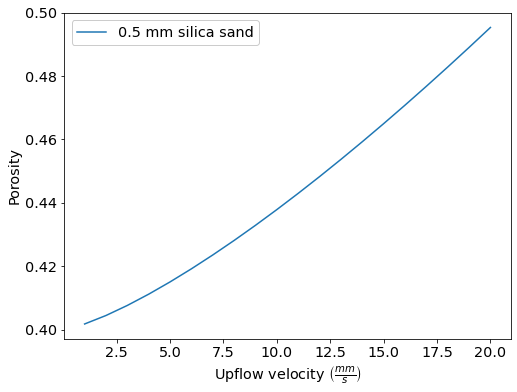

In [5]:
temp = 20 * u.degC
sand_D = 0.5 * u.mm
sand_RHO = 2650 * u.kg/u.m**3
filter_W = 1 * u.m
filter_L = 1 * u.m
hydraulic_D = d_hydraulic(filter_W,filter_L)

static_bed_PHI = 0.4
v_z = np.linspace(1,20,20) * 1 * u.mm/u.s
sand_PHI = porosity_fluidized_bed(temp, sand_RHO , sand_D, hydraulic_D,static_bed_PHI, v_z)
plt.plot(v_z,sand_PHI)
plt.legend(["0.5 mm silica sand"])
plt.ylabel(r"Porosity")
plt.xlabel(r"Upflow velocity $\left(\frac{mm}{s}\right)$")


#Terminal velocity of flocs

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False

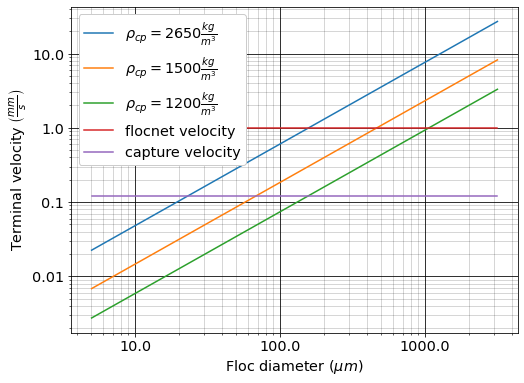

In [6]:
flocD = np.logspace(0.7,3.5,50) * 1*u.um 
Temp = 20*u.degC
coreRHO = 2650 * u.kg/u.m**3
coreD = 5 * u.um
fractalPI = 2.1
plt.loglog(flocD,vel_term_floc(coreD, 2650 * u.kg/u.m**3, fractalPI, flocD, Temp))
plt.loglog(flocD,vel_term_floc(coreD, 1500 * u.kg/u.m**3, fractalPI, flocD, Temp))
plt.loglog(flocD,vel_term_floc(coreD, 1200 * u.kg/u.m**3, fractalPI, flocD, Temp))
plt.loglog(flocD,np.full_like(flocD,1*u.mm/u.s))
plt.loglog(flocD,np.full_like(flocD,0.12*u.mm/u.s))

# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='black', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)
plt.legend([r"$\rho_{cp} = 2650\frac{kg}{m^3}$",r"$\rho_{cp} = 1500\frac{kg}{m^3}$",r"$\rho_{cp} = 1200\frac{kg}{m^3}$", "flocnet velocity", "capture velocity"])
plt.ylabel(r"Terminal velocity $\left(\frac{mm}{s}\right)$")
plt.xlabel(r"Floc diameter $(\mu m)$")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


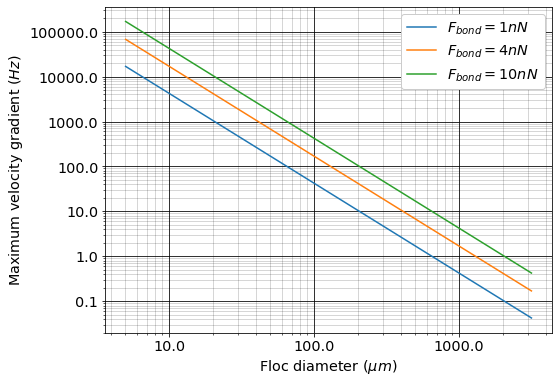

In [7]:
#max velocity gradient as function of floc diameter
bondF = 4 * u.nN
plt.loglog(flocD,GmaxofFlocD(1 * u.nN,flocD,Temp))
plt.loglog(flocD,GmaxofFlocD(4 * u.nN,flocD,Temp))
plt.loglog(flocD,GmaxofFlocD(10 * u.nN,flocD,Temp))
# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='black', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)
plt.legend([r"$F_{bond} = 1nN$",r"$F_{bond} = 4nN$",r"$F_{bond} = 10nN$"])
plt.ylabel(r"Maximum velocity gradient $\left(Hz\right)$")
plt.xlabel(r"Floc diameter $(\mu m)$")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))

[0.01 0.622 1.234 1.846 2.458 3.07 3.682 4.294 4.906 5.518 6.13 6.742 7.354 7.967 8.579 9.191 9.803 10.41 11.03 11.64 12.25 12.86 13.47 14.09 14.7 15.31 15.92 16.54 17.15 17.76 18.37 18.98 19.6 20.21 20.82 21.43 22.04 22.66 23.27 23.88 24.49 25.1 25.72 26.33 26.94 27.55 28.16 28.78 29.39 30] degree_Celsius


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


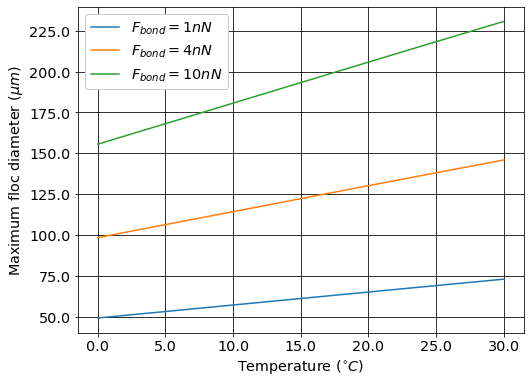

In [8]:
# floc size as a function of temperature
TempGraph = np.linspace(0.01,30,50) * u.degC
print(TempGraph)
Gmax = 100 * u.Hz
plt.plot(TempGraph,flocDofG(1 * u.nN,Gmax,TempGraph))
plt.plot(TempGraph,flocDofG(4 * u.nN,Gmax,TempGraph))
plt.plot(TempGraph,flocDofG(10 * u.nN,Gmax,TempGraph))

# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='black', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)
plt.legend([r"$F_{bond} = 1nN$",r"$F_{bond} = 4nN$",r"$F_{bond} = 10nN$"])
plt.xlabel(r"Temperature $(^{\circ}C)$")
plt.ylabel(r"Maximum floc diameter $\left(\mu m\right)$")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


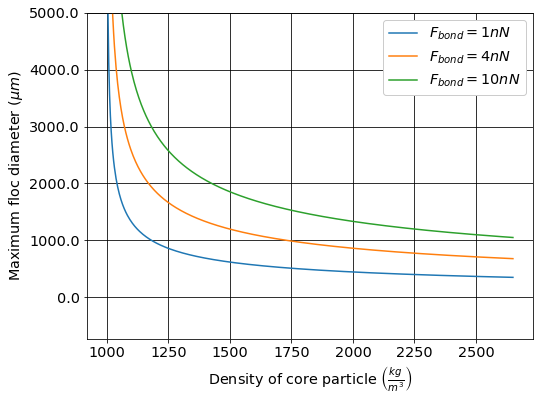

In [9]:
#Floc size in gravity as function of core density

coreDensity = np.linspace(1.001,2.65,500) * 1000 * u.kg/u.m**3
bondgPI = 8
coreD = 5 * u.um

plt.plot(coreDensity,flocDofGravity(coreD, coreDensity, fractalPI, 1 * u.nN, bondgPI, Temp))
plt.plot(coreDensity,flocDofGravity(coreD, coreDensity, fractalPI, 4 * u.nN, bondgPI, Temp))
plt.plot(coreDensity,flocDofGravity(coreD, coreDensity, fractalPI, 10 * u.nN, bondgPI, Temp))

# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='black', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)
plt.legend([r"$F_{bond} = 1nN$",r"$F_{bond} = 4nN$",r"$F_{bond} = 10nN$"])
plt.xlabel(r"Density of core particle $\left(\frac{kg}{m^3}\right)$")
plt.ylabel(r"Maximum floc diameter $\left(\mu m\right)$")
plt.ylim(top=5000)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))
#plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


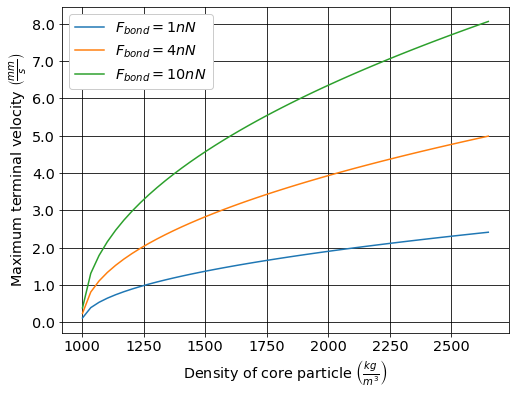

In [10]:
vel_term_floc_max(coreD, coreRHO, fractalPI, bondF, bondgPI, Temp)

#Floc maximum terminal velocity as a function of core density

coreDensity = np.linspace(1.001,2.65,50) * 1000 * u.kg/u.m**3
bondgPI = 8
coreD = 5 * u.um

plt.plot(coreDensity,vel_term_floc_max(coreD, coreDensity, fractalPI, 1 * u.nN, bondgPI, Temp))
plt.plot(coreDensity,vel_term_floc_max(coreD, coreDensity, fractalPI, 4 * u.nN, bondgPI, Temp))
plt.plot(coreDensity,vel_term_floc_max(coreD, coreDensity, fractalPI, 10 * u.nN, bondgPI, Temp))


# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='black', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)
plt.legend([r"$F_{bond} = 1nN$",r"$F_{bond} = 4nN$",r"$F_{bond} = 10nN$"])
plt.xlabel(r"Density of core particle $\left(\frac{kg}{m^3}\right)$")
plt.ylabel(r"Maximum terminal velocity $\left(\frac{mm}{s}\right)$")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))

# Linking Velocity Gradient and Capture Velocity


 $$G_{max} \approx  \frac{4F_{bond}}{3 \pi \nu^3 \rho_{H_2O}}\left(  \frac{g D_{cp}}{18 v_c} \frac{\rho_{cp} - \rho_{H_2O}}{\rho_{H_2O}}\right) ^2$$

 The following graph shows the dramatic effect on temperature on the maximum velocity gradient that can be used in the flocculator. 

1.75e+04 milliwatt ** 0.5 * second ** 0.5 / kilogram ** 0.5 / meter
563 hertz
5.205 millimeter ** 8 / second ** 6


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


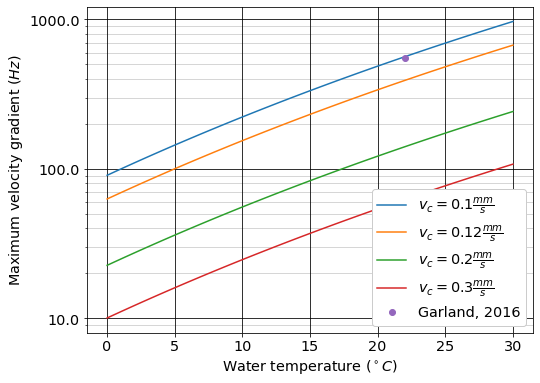

In [11]:
@ac.list_handler()
def maxflocG(bondF,Temp,Dcp,Rhocp, captureVelocity):
  """
  Calculates the maximum velocity gradient.
  """
  Nu = ac.viscosity_kinematic_water(Temp)
  water_RHO = ac.density_water(Temp)
  return (4*bondF/(3 * np.pi * Nu**3 * water_RHO) * 
          (u.gravity * Dcp * (Rhocp - water_RHO)
          /(18 * captureVelocity * water_RHO))**2).to(u.Hz)

CaseyEDR_max = 300 * u.mW/u.kg
CaseyTemp = 21 * u.degC
CaseyG_cs = np.sqrt(CaseyEDR_max/ac.viscosity_kinematic_water(CaseyTemp))
print(CaseyG_cs)

bondF = 0.57 * u.nN

Temp = 22 * u.degC
Dcp = 5 * u.um 
Rhocp = 2650 * u.kg/u.m**3
captureVelocity = 0.10 * u.mm/u.s
print(maxflocG(bondF,Temp,Dcp,Rhocp, captureVelocity))  

zeta = (ac.viscosity_kinematic_water(CaseyTemp)**3 * captureVelocity**2 * CaseyG_cs.to(1/u.second)).to(u.mm**8/u.second**6)
print(zeta)
# now create a graph of G as a function of temperature
graphTemp = np.linspace(0,30,50) * u.degC

plt.plot(graphTemp,maxflocG(bondF,graphTemp,Dcp,Rhocp, 0.1 * u.mm/u.s))
plt.plot(graphTemp,maxflocG(bondF,graphTemp,Dcp,Rhocp, 0.12 * u.mm/u.s))
plt.plot(graphTemp,maxflocG(bondF,graphTemp,Dcp,Rhocp, 0.2 * u.mm/u.s ))
plt.plot(graphTemp,maxflocG(bondF,graphTemp,Dcp,Rhocp, 0.3 * u.mm/u.s))
plt.plot(Temp,CaseyG_cs.to(u.Hz), "o")
# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='black', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)
plt.legend([r"$v_{c} = 0.1 \frac{mm}{s}$",r"$v_{c} = 0.12 \frac{mm}{s}$",r"$v_{c} = 0.2 \frac{mm}{s}$",r"$v_{c} = 0.3 \frac{mm}{s}$", "Garland, 2016"])
plt.xlabel(r"Water temperature $\left(^\circ C \right)$")
plt.ylabel(r"Maximum velocity gradient $\left(Hz\right)$")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))

1.771e+04 milliwatt ** 0.5 * second ** 0.5 / kilogram ** 0.5 / meter
4.906 millimeter ** 8 / second ** 6


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


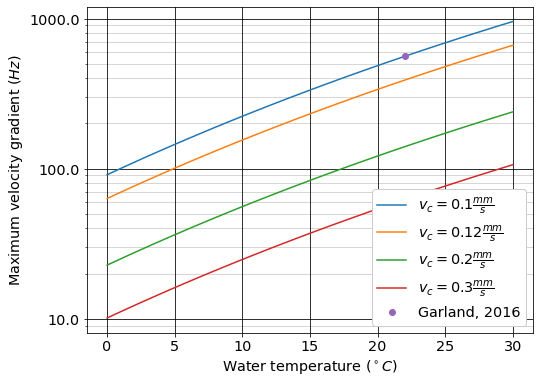

In [12]:
@ac.list_handler()
def maxflocGofZeta(zeta,Temp, captureVelocity):
  """
  Calculates the maximum velocity gradient.
  """
  Nu = ac.viscosity_kinematic_water(Temp)
  return (zeta/(Nu**3 * captureVelocity**2)).to(u.Hz)

CaseyEDR_max = 300 * u.mW/u.kg
CaseyTemp = 22 * u.degC
CaseyG_cs = np.sqrt(CaseyEDR_max/ac.viscosity_kinematic_water(CaseyTemp))
print(CaseyG_cs)
Temp = 22 * u.degC
captureVelocity = 0.10 * u.mm/u.s
zeta = (ac.viscosity_kinematic_water(CaseyTemp)**3 * captureVelocity**2 * CaseyG_cs.to(1/u.second)).to(u.mm**8/u.second**6)
print(zeta)
# now create a graph of G as a function of temperature
graphTemp = np.linspace(0,30,50) * u.degC

plt.plot(graphTemp,maxflocGofZeta(zeta,graphTemp, 0.1 * u.mm/u.s))
plt.plot(graphTemp,maxflocGofZeta(zeta,graphTemp, 0.12 * u.mm/u.s))
plt.plot(graphTemp,maxflocGofZeta(zeta,graphTemp, 0.2 * u.mm/u.s ))
plt.plot(graphTemp,maxflocGofZeta(zeta,graphTemp, 0.3 * u.mm/u.s))
plt.plot(Temp,CaseyG_cs.to(u.Hz), "o")
# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='black', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.grid(b=True, which='minor', color='black', linestyle='-', alpha=0.2)
plt.legend([r"$v_{c} = 0.1 \frac{mm}{s}$",r"$v_{c} = 0.12 \frac{mm}{s}$",r"$v_{c} = 0.2 \frac{mm}{s}$",r"$v_{c} = 0.3 \frac{mm}{s}$", "Garland, 2016"])
plt.xlabel(r"Water temperature $\left(^\circ C \right)$")
plt.ylabel(r"Maximum velocity gradient $\left(Hz\right)$")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}"))

In [13]:
water_RHO = ac.density_water(Temp)
Fbond = (3/4 * np.pi * water_RHO * zeta *((18/(Dcp * u.gravity)) * (water_RHO/(Rhocp-water_RHO)))**2).to(u.N)
print(Fbond)

5.669e-10 newton
